In [1]:
import yfinance as yf 
import pandas as pd
import numpy as np
from datetime import datetime

import quandl

import sys
import urllib
import os
from matplotlib import pylab as plt 

import quandl

import seaborn as sns

import sys

from scipy.stats import norm
import ezodf

import scipy.optimize as sco
import scipy

from sklearn.covariance import LedoitWolf
import sklearn.datasets, sklearn.decomposition

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def strategy_evaluation(result, data_names, freq = 'D'):

    
    port = pd.DataFrame(result)
    port_ret = calc_port_ret(port)
    
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], 
                               axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.1%}", 'Volatility': "{:.1%}",
              'Sharpe': "{:.1f}",'MAR': "{:.2f}", 'Sortino': "{:.1f}" })
      .set_table_styles(styles)
      .set_properties(**{'color': 'black'}))
    
    return metrics


def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    


    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)

    
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        

        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0]))]},
                  index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
                           
                  #index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    metrics[metrics.isna()] = 0
    
    return metrics 



def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret


def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles)
          .set_properties(**{'color': 'black'}))
    
    return corr

In [3]:
def calc_bond_returns(YTM, YTMM1, M, FREQ = 12):
    DY = YTM - YTMM1
    yield_income = (1+YTM)**(1/FREQ) - 1
    Z = (1+(YTM/2))
    

    duration = (1/YTM)* (1 -(1/(1+0.5*YTM)**(2*M)))


    C1 = (2/YTM**2) * (1-Z**(-2*M))
    C2 = ((2*M)/YTM) * Z **(-2*M - 1) 
    convex = C1-C2

    ret = yield_income - duration* DY + (1/2)*convex * (DY**2)
    return(ret)



def monthly_bonds_ret(bond_YTM, M):
    bond_ret = [0]

    for i in range(len(bond_YTM)-1):
        YTM = bond_YTM[i+1]
        YTMM1 = bond_YTM[i]
        
        ret = calc_bond_returns(YTM, YTMM1, M)
        bond_ret.append(ret)

    bond_ret = pd.DataFrame(bond_ret)
    #bond_ret.index = bond_YTM.index + pd.Timedelta('1 day')
    bond_ret.index = bond_YTM.index
    
    bond_ret = (bond_ret+1).cumprod()
    return(bond_ret)


In [4]:
def PCA_cov(data, N = 5):
    #X = data.cov()
    
    X = data.ewm(span = 252).cov()
    DATE_IDX = X.index.get_level_values(level=0)[-1]
    X = X[X.index.get_level_values(0)==DATE_IDX].droplevel(0)
    mu = np.mean(X, axis=0)

    pca = sklearn.decomposition.PCA()
    pca.fit(X)

    nComp = N
    Xhat = np.dot(pca.transform(X)[:,:nComp], pca.components_[:nComp,:])
    Xhat += mu
    clean_cov = pd.DataFrame(Xhat)
    clean_cov.index = X.index
    clean_cov.columns = X.index
    return(clean_cov)

## Implementation of MAN AHL Trend System,

- use multiple MAs
- Weight by signal strength

In [5]:
def risk_parity(data):
    
    vol = data.std()

    sum_vol = 0
    for i in range(len(vol)):
        sum_vol =sum_vol + (1/vol[i])
    
    weight = []
    for i in range(len(vol)):
        w = (1/vol[i])/(sum_vol)
        weight.append(w)
   
    weight = [round(num, 2) for num in weight]
    return(weight)


def equal_weight(data):
    num_assets = len(data.columns)
    weight = num_assets*[1./num_assets,]
    
    return(weight)
    

def get_weights(data, method, lookback):
    weights = []
 

    for i in range(lookback,len(data)):
    
        W= method(data[i-lookback:i])
        weights.append(W)

    weights = pd.DataFrame(weights)
    weights.index = data[lookback:].index
    weights.columns = data.columns
    
    return(weights)

In [6]:
def ERC_weight(data):
    
    num_assets = len(data.columns)
    #data = data.dropna()
    cov_fit = LedoitWolf().fit(data)
    cov = cov_fit.covariance_

        
    args = (cov)
    constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
        
    result = sco.minimize(erc, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints, tol = 0.00000000000000000000000000000000000001)
    weights = result['x']
        
        
        
    
    return (weights)

def kelly_objective(weights,ret, cov, risk_free = 0):
    
    #kelly_ret = port_ret(weights, ret)
    kelly_ret = port_ret(weights, ret) - port_var(weights, cov)/2
    
    obj = -(kelly_ret)
    
    return(obj)

def sharpe_objective(weights,ret, cov, risk_free = 0):
    ret = port_ret(weights, ret)
    std = port_var(weights, cov)**(1/2)
    
    obj = - (ret/std)
    return(obj)


def port_var(weights, cov):
    var = weights.dot(cov).dot(weights)
    return(var)

def port_ret(weights, ret, risk_free = 0):
    #needs to be array
    ret = ret - risk_free
    port_ret = weights.dot(ret)
    return(port_ret)



def calc_diversification_ratio(weights, cov):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(cov)), weights.T)
    # portfolio vol
    port_vol = np.sqrt(port_var(weights, cov))
    
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio

def erc(weights, cov):
        # these are non normalized risk contributions, i.e. not regularized
        # by total risk, seems to help numerically
        risk_contributions = np.dot(weights, cov) * weights
        a = np.reshape(risk_contributions, (len(risk_contributions), 1))
        # broadcasts so you get pairwise differences in risk contributions
        risk_diffs = a - a.transpose()
        sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))/10000000
        # https://stackoverflow.com/a/36685019/1451311
        return sum_risk_diffs_squared #/ scale_factorcov

In [29]:
TICKS = ['GLD']
assets_df = pd.DataFrame()
for tick in TICKS:
    
    price = yf.download(tick,start='2000-01-01', progress = False, threads = False)
    
    log_ret = np.log(ret_df['Adj Close'].pct_change()+1)
    price = pd.DataFrame(price['Adj Close'])
    
    price['Asset'] = tick
    assets_df = pd.concat([assets_df,price] )


#ret_df = assets_df.pct_change()
#ret_df= ret_df.dropna()

In [38]:
period= 5
ret_df = assets_df
ret_df['log_ret'] = np.log(ret_df['Adj Close'].pct_change()+1)
ret_df['fwd_ret'] = (ret_df['log_ret'] - 1).rolling(period).sum().shift(-period)

In [39]:
ret_df['Adj Close']

,Adj Close,Asset,log_ret,5_day_ret,fwd_5_day_ret,fwd_ret
Date,,,,,,
2004-11-18,44.380001,GLD,NaN,NaN,-4.979703,-4.979703
2004-11-19,44.779999,GLD,0.008973,NaN,-4.986249,-4.986249
2004-11-22,44.950001,GLD,0.003789,NaN,-4.996225,-4.996225
2004-11-23,44.750000,GLD,-0.004459,NaN,-4.986020,-4.986020
2004-11-24,45.049999,GLD,0.006682,NaN,-5.002222,-5.002222
...,...,...,...,...,...,...
2022-07-25,160.229996,GLD,-0.002742,-4.993300,NaN,NaN
2022-07-26,160.039993,GLD,-0.001187,-4.996871,NaN,NaN
2022-07-27,161.669998,GLD,0.010133,-4.977291,NaN,NaN


In [53]:
lookback = [63]
lookback_ewm = 120
weights = np.ones(len(TICKS))/len(TICKS)
target_vol_ewm = 0.10

vol_lookback = max(lookback)
vol = ret_df['log_ret'].rolling(vol_lookback).std()

look_back_dict = {}
df_signals = pd.DataFrame()
for look in lookback:
    trend_tmp = ret_df['Adj Close'].ewm(span=look).mean() - ret_df['Adj Close'].ewm(span=4*look).mean()
    scld_trend = trend_tmp/vol
    trend_norm = scld_trend/scld_trend.rolling(252).std()
    trend_sig = (trend_norm * np.exp((-trend_norm**2)/4))/0.89
    trend_sig = trend_sig.dropna()
    forcast_scalar = 10/0.55 #mean asbolute forcast
    forecasts = trend_sig *forcast_scalar
    ##
    forecasts[forecasts>20] = 20
    forecasts[forecasts<-20] = -20
    ##
    look_back_dict[look] = forecasts
    ret_df['forecast'] = forecasts




In [54]:
ret_df

,Adj Close,Asset,log_ret,5_day_ret,fwd_5_day_ret,fwd_ret,forecast
Date,,,,,,,
2004-11-18,44.380001,GLD,NaN,NaN,-4.979703,-4.979703,NaN
2004-11-19,44.779999,GLD,0.008973,NaN,-4.986249,-4.986249,NaN
2004-11-22,44.950001,GLD,0.003789,NaN,-4.996225,-4.996225,NaN
2004-11-23,44.750000,GLD,-0.004459,NaN,-4.986020,-4.986020,NaN
2004-11-24,45.049999,GLD,0.006682,NaN,-5.002222,-5.002222,NaN
...,...,...,...,...,...,...,...
2022-07-25,160.229996,GLD,-0.002742,-4.993300,NaN,NaN,-17.279340
2022-07-26,160.039993,GLD,-0.001187,-4.996871,NaN,NaN,-17.498885
2022-07-27,161.669998,GLD,0.010133,-4.977291,NaN,NaN,-17.520169


## Trend Strength Analysis

In [88]:
#pd.DataFrame(np.multiply(df_signals[:len(ret_df) - len(df_signals)],ret_df).sum(axis =1))
ASSET = 'DBC'


signal_s = pd.concat([df_signals[len(ret_df) - len(df_signals):][ASSET], ret_df[ASSET].shift(-5)], axis = 1)
signal_s.columns = ["signal", "ret"]

signal_s = signal_s.resample('W').last()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


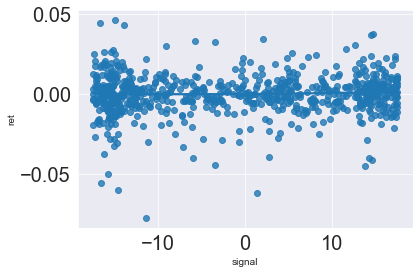

In [89]:
import seaborn as sns

sns.regplot(signal_s['signal'], signal_s['ret'], lowess=True);